# Contextual Advertizing for Health Related Articles

## Introduction

In today's digital age, the web is a vast repository of information, offering an array of content spanning diverse topics and interests. For businesses engaged in online advertising, reaching the right audience with the right message is paramount. For this project, I am assuming the role of a media buying company that is working with a client that wants to target advertizements on health related articles. My objective is to create a model that can look at a short description of an article and perform a binary classification task of either "Health Related" or "Not Health Related".

## Imports / Drive / Other Utility Actions

Here are the libraries that we will be using as well as some other functions and actions that we need to set up the notebook.

In [1]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
try:
  from wordcloud import WordCloud, STOPWORDS
except:
  !pip install wordcloud
  os.kill(os.getpid(), 9)
from wordcloud import WordCloud, STOPWORDS
import ktrain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


## Dataset

The dataset I am using for this project contains 200,853 articles. The entries have a headline, a short description and a category. There are other columns as well but we are not concerned with these for this project.

In [4]:
reviews = pd.read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/news_category_trainingdata.json")
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## EDA / Preprocessing

### Preprocess the Columns

I will start the data preprocessing by combining the "Headline" and "Short Description" columns into one. We need a single string per article for our machine learning training to work. Since we are interested in a binary classification task, we also need to reformat the categories into Healthy and Other categories.


We can see that the resulting new column has a very skewed distribution with only 3.3% of the data being a "Healthy Living" article. With unbalanced datasets like these, it is wise to balance the datasets to improve results. We should also be mindful of evaluation matrics because accuracy can be very high even for a model that only predicts one category.


In [5]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

In [6]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)
reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

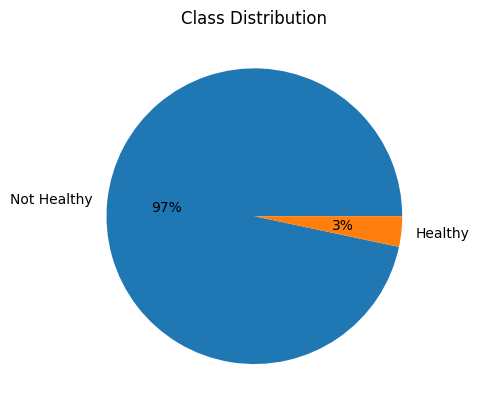

In [11]:

plt.pie(reviews['healthy'].value_counts(), labels=['Not Healthy', 'Healthy'], autopct='%1.0f%%')
plt.title('Class Distribution')
plt.show()

### Balance the Data

I will balance the data by undersampling the "Not Healthy category". There are multiple ways or ratios that I can use for this process but I will go with a equal ratio for "Healthy" to "Not Healthy" articles. After multiple runs with different splits, I found that a balanced dataset performed best. When I tried increasing the number of "Not Healthy" articles, the models tended to predict everything to "Not Healthy" and did not optimize well.


In [12]:
sample_amount =  len(reviews[reviews["healthy"] == 1])

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

review_sample = pd.concat([healthy,not_healthy])

review_sample.describe()

,healthy
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Word Clouds

We can see word clouds for the most common words found in either category below. A simple model may just look at the common words found in each category and use that to classify the articles. But this does not account for the context the words are used in. We will be using a BERT based tokenizer to first tokenize and vectorize the data before using training a deep neural network.

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

def generate_word_cloud(category):
    cat = 1 if category == 'HEALTHY LIVING' else 0
    col = 'white' if category == 'HEALTHY LIVING' else 'black'

    category_df = reviews[reviews['healthy'] == cat]

    text = ' '.join(category_df['combined_text'])

    wordcloud = WordCloud(width=800, height=800,
                          background_color=col,
                          max_words=100).generate(text)

    wordcloud.to_file(f'/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/{category}_wordcloud.png')

generate_word_cloud('HEALTHY LIVING')
generate_word_cloud('NOT HEALTHY LIVING')

health_cloud = mpimg.imread('/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/HEALTHY LIVING_wordcloud.png')
other_cloud = mpimg.imread('/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/NOT HEALTHY LIVING_wordcloud.png')


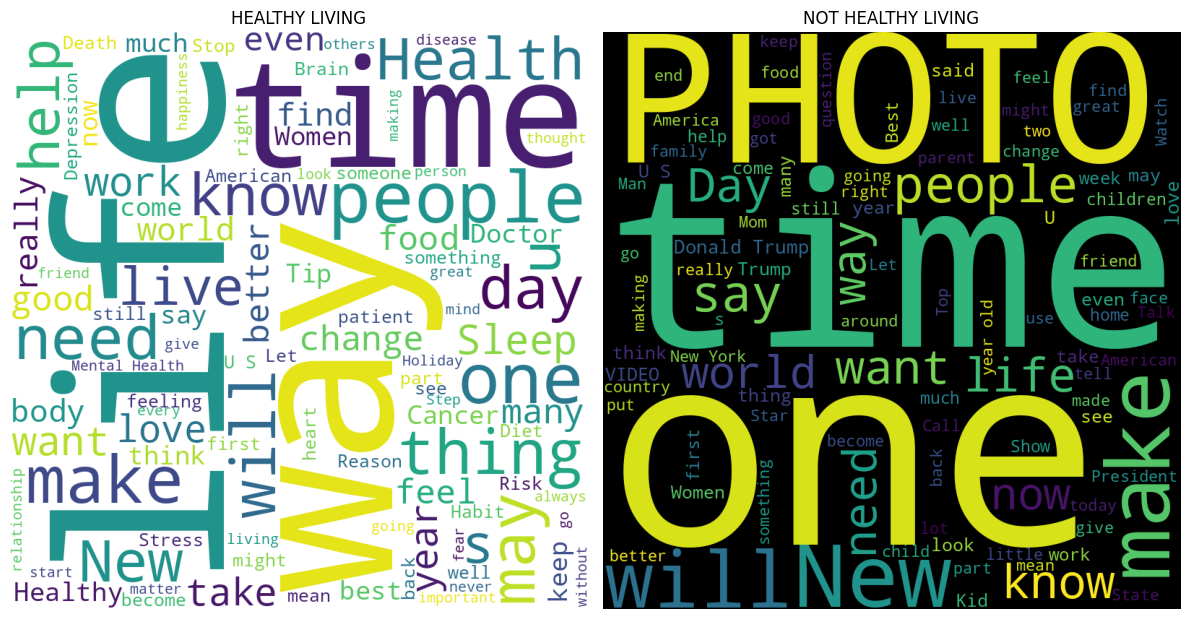

In [14]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.imshow(health_cloud)
plt.axis('off')
plt.title('HEALTHY LIVING')

plt.subplot(1, 2, 2)
plt.imshow(other_cloud)
plt.axis('off')
plt.title('NOT HEALTHY LIVING')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/combined_wordcloud.png')
plt.show()

## Model

Before I can start training, I need to convert the strings of text into vectors. I will be using ktrain's texts_from_df to encode the data. I will also figure out the appropriate learning rate for the training using lr_find. This will simulate training for various learning rates to find the optimal value. The max_features is an interesting hyperparameter that can be adjusted for this task. It will limit the number of unique words to consider when creating the word embedding. I found that reducing the max_features to 5000 improved the model accuracy.

In [35]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

In [46]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=5000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=0
)

['not_healthy', 'healthy']
        not_healthy  healthy
142692          1.0      0.0
5982            1.0      0.0
91955           0.0      1.0
9470            1.0      0.0
33093           0.0      1.0
['not_healthy', 'healthy']
        not_healthy  healthy
95578           0.0      1.0
42486           1.0      0.0
3726            1.0      0.0
17336           1.0      0.0
113852          1.0      0.0


In [47]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [48]:
learner.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
753/753 [==============================] - 656s 857ms/step - loss: 0.5820 - accuracy: 0.7324
Epoch 2/5
753/753 [==============================] - 646s 860ms/step - loss: 0.3650 - accuracy: 0.8493
Epoch 3/5
753/753 [==============================] - 644s 855ms/step - loss: 0.6146 - accuracy: 0.5987
Epoch 4/5
753/753 [==============================] - 634s 841ms/step - loss: 0.7093 - accuracy: 0.5065
Epoch 5/5
753/753 [==============================] - 633s 840ms/step - loss: 0.8578 - accuracy: 0.4990


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Looking at the learning rate vs. loss plot below, we can see that the best learning rate is somewhere between $10^{-5}$ and $10^{-4}$. I will choose $10^{-5}$ as the learning rate.

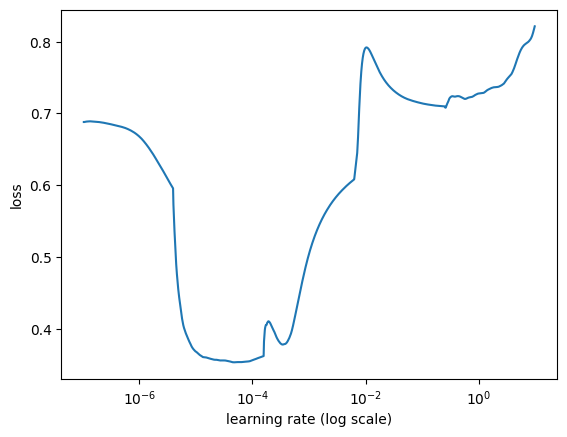

In [49]:
learner.lr_plot()

In [50]:
history=learner.autofit(
    1e-5,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/10
754/754 [==============================] - 676s 875ms/step - loss: 0.3942 - accuracy: 0.8317 - val_loss: 0.3490 - val_accuracy: 0.8521
Epoch 2/10
754/754 [==============================] - 661s 877ms/step - loss: 0.2679 - accuracy: 0.8945 - val_loss: 0.3326 - val_accuracy: 0.8633
Epoch 3/10
754/754 [==============================] - 654s 867ms/step - loss: 0.2042 - accuracy: 0.9249 - val_loss: 0.3482 - val_accuracy: 0.8626
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [51]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

## Results

The evaluation metrics for prediction on the validation set are shown below. The accuracy is 0.86 and the f1-score is 0.88. These results are pretty satisfactory for this classification task. Our precision is lower than the recall which means the model tends to slightly overpredict for the "Healthy" articles.

In [52]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 7s 137ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       631
           1       0.84      0.92      0.88       708

    accuracy                           0.86      1339
   macro avg       0.87      0.86      0.86      1339
weighted avg       0.87      0.86      0.86      1339



### Unseen Data

Let's test the model out on some unseen data. Here are some articles that don't exist that the model has not seen.

In [53]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

healthy_living_snippets = [
    'Discover the Benefits of Yoga and Meditation. Unwind your mind and strengthen your body with regular yoga and meditation practice.',
    'Healthy Eating Habits for a Longer Life. Learn about the importance of balanced nutrition and its impact on longevity and overall well-being.',
    'The Power of Organic Foods. Explore the benefits of organic produce and how it contributes to a healthier lifestyle.',
    'Tips for a Restful Sleep. Improve your sleep quality with simple techniques like creating a calming bedtime routine and optimizing your sleep environment.'
]

non_healthy_living_snippets = [
    'Latest Fashion Trends for the Fall Season. Stay stylish this autumn with the hottest fashion trends and wardrobe essentials.',
    'New Technology Gadgets You Must Try. Explore the latest gadgets and tech innovations that are shaping the future.',
    'Exploring Art and Culture in the City. Dive into the rich cultural scene of the city with art exhibitions, theater performances, and live music shows.',
    'Travel Destinations to Add to Your Bucket List. Plan your next adventure with these breathtaking travel destinations from around the world.'
]

In [54]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)
for i, text in enumerate(healthy_living_snippets):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)
for i, text in enumerate(non_healthy_living_snippets):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.9297534
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.94289947
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.9253198
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.9402907
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.0063078217
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The 

The model successfully predicted all of the examples correctly.

## Conclusion

In this project, I have trained a bert-based model that can successfully distinguish between healthy and not healthy articles. The aim was to create this model for use in a targeted advertisement campaign. This model can classify articles at a high accuracy which will be beneficial for the advertizing health related products.

The biggest impact hyperparameter tuning that I did was tweaking the max_features of the word embedding and the learning rate for training.